<a href="https://colab.research.google.com/github/Karthick47v2/question-generator/blob/main/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Add opt

### Install 3rd party libraries

In [1]:
!pip3 install pytorch-lightning==1.7.0
 # newwer version not works with FastT5 (for ONNX conversion)
!pip3 install transformers==4.1.1
!pip3 install tokenizers==0.9.4
!pip3 install sentencepiece==0.1.94

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 700 kB 33.6 MB/s 
     |████████████████████████████████| 5.8 MB 49.7 MB/s 
     |████████████████████████████████| 596 kB 57.5 MB/s 
     |████████████████████████████████| 419 kB 71.9 MB/s 
     |████████████████████████████████| 141 kB 75.3 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.9.1 which is inc

### Import libraries

> You ***may*** need to restart runtime after installing python packages. (If importing `pytorch_lightning` throws error)

In [2]:
import os
import pandas as pd
import torch
import pytorch_lightning as pl

from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, T5ForConditionalGeneration, T5Tokenizer
from sklearn.model_selection import train_test_split

pl.seed_everything(42)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


42

### Load and split dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
dataset = 'sciq' ## squad or sciq

df = pd.read_csv(f"gdrive/MyDrive/mcq-gen/{'SQuAD' if dataset == 'squad' else 'SciQ'}-processed.csv")

In [5]:
train_df, validation_df = train_test_split(df, test_size=0.1, shuffle=True)
validation_df, test_df = train_test_split(validation_df, test_size=0.4)
train_df.shape, validation_df.shape, test_df.shape

((10775, 3), (718, 3), (480, 3))

### Load base model

In [6]:
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

### Dataset code


In [7]:
class QADataset(Dataset):
  def __init__(self, tokenizer, data, max_out_len, max_in_len=512):
    """Initialize Dataset.

    Args:
      tokenizer (T5Tokenizer): Text tokenizer for T5 transformer.
      data (DataFrame): Dataset.
      max_out_len (int): Maximum model output token length.
      max_in_len (int): Maximum model input token length. Defaults to 512.
    """
    self.data = data
    self.max_in_len = max_in_len
    self.max_out_len = max_out_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []
    self.__tokenize()

  def __len__(self):
    """Get number of rows / inputs.
    
    Returns:
      (int): Number of dat inputs.  
    """
    return len(self.data)

  def __getitem__(self, index):
    """ Get item by index.
    """    
    labels = self.targets[index]["input_ids"]
    labels[labels==0] = -100

    return {'context': self.data.iloc[index]['context'], 
            'answer': self.data.iloc[index]['answer'], 
            'question': self.data.iloc[index]['question'],
            'input_ids': self.inputs[index]["input_ids"].flatten(),
            'attention_mask': self.inputs[index]["attention_mask"].flatten(),
            'labels': labels.flatten(),
            'labels_attention_mask': 
            self.targets[index]["attention_mask"].flatten()
            }

  def __tokenize(self):
    """Tokenize text data and store it to reduce computation while training."""
    for _, row in self.data.iterrows():
      context, answer, question = row['context'], row['answer'], row['question']

      source_encoding = self.tokenizer(
                              context, answer,
                              max_length=self.max_in_len,
                              padding='max_length',
                              truncation='only_first',
                              return_attention_mask=True,
                              add_special_tokens=True,
                              return_tensors='pt'
                              )
      
      target_encoding = self.tokenizer(
                              question,
                              max_length=self.max_out_len,
                              padding='max_length',
                              truncation=True,
                              return_attention_mask=True,
                              add_special_tokens=True,
                              return_tensors='pt'
                              )
      
      self.inputs.append(source_encoding)
      self.targets.append(target_encoding)

In [8]:
class QADataModule(pl.LightningDataModule):
  def __init__(self, train_df, validation_df, test_df, tokenizer, batch_size, 
               max_out_len, max_in_len=512):
    """Initialize DataModule.
    
    Args:
      train_df (DataFrame): Train dataset.
      validation_df (DataFrame): Validation dataset.
      test_df (DataFrame): Test dataset.
      tokenizer (T5Tokenizer): Text tokenizer for T5 transformer.
      batch_size (int): No. of samples in one fwd/bkwd pass.
      max_out_len (int): Maximum model output token length.
      max_in_len (int): Maximum model input token length. Defaults to 512.

      """
    super().__init__()
    self.train_df = train_df
    self.validation_df = validation_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_in_len = max_in_len
    self.max_out_len = max_out_len

  def setup(self, stage=None):
    """Setup dataset.
    
    Args:
      stage Optional(str): setup dataset when needed ('fit',..) 
    """
    self.train_dataset = QADataset(self.tokenizer, self.train_df, 
                                   self.max_out_len, self.max_in_len)
    self.validation_dataset = QADataset(self.tokenizer, self.validation_df, 
                                        self.max_out_len, self.max_in_len)
    self.test_dataset = QADataset(self.tokenizer, self.test_df, 
                                  self.max_out_len, self.max_in_len)
    
  def train_dataloader(self):
    """Generate iterator for train dataset.
    
    Returns:
      (DataLoader): Iterator for train dataset
    """
    return DataLoader(self.train_dataset, batch_size=self.batch_size, 
                      shuffle=True, num_workers=os.cpu_count())
    
  def val_dataloader(self):
    """Generate iterator for validation dataset.
    
    Returns:
      (DataLoader): Iterator for validation dataset
    """
    return DataLoader(self.validation_dataset, batch_size=2, 
                      num_workers=os.cpu_count())
    
  def test_dataloader(self):
    """Generate iterator for test dataset.
    
    Returns:
      (DataLoader): Iterator for test dataset
    """
    return DataLoader(self.test_dataset, batch_size=2,
                      num_workers=os.cpu_count())

### Model training code

In [9]:
class QAModel(pl.LightningModule):
  def __init__(self, learning_rate=None):
    """Initialize LightningModule

    Args:
      learning_rate Optional(double): Model learning rate
    """
    super().__init__()
    self.model = T5ForConditionalGeneration.from_pretrained('t5-base', 
                                                            return_dict=True)
    self.lr = learning_rate

  def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
    outputs = self.model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=decoder_attention_mask,
        labels=labels,
    )
    return outputs.loss, outputs.logits

  def training_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels_attention_mask = batch['labels_attention_mask']
    labels = batch['labels']

    loss, outputs = self(input_ids, attention_mask, labels_attention_mask,
                         labels)

    self.log("train_loss", loss, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels_attention_mask = batch['labels_attention_mask']
    labels = batch['labels']

    loss, outputs = self(input_ids, attention_mask, labels_attention_mask,
                         labels)

    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels_attention_mask = batch['labels_attention_mask']
    labels = batch['labels']

    loss, outputs = self(input_ids, attention_mask, labels_attention_mask,
                         labels)

    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):
    return AdamW(self.parameters(), lr=self.lr, eps=1e-8)

In [10]:
BATCH_SIZE = 8
N_EPOCHS = 3
MAX_LR = 1e-2

### Find best LR

In [11]:
data_module = QADataModule(train_df, validation_df, test_df, t5_tokenizer, BATCH_SIZE, 72) # 48 / 72
data_module.setup()

In [12]:
model = QAModel(learning_rate = MAX_LR)
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=20)

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [13]:
lr_finder = trainer.tuner.lr_find(model, data_module, max_lr=MAX_LR)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_1013db15-daca-421c-93f4-6fe8643b1401.ckpt


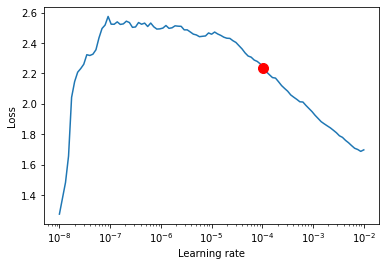

In [14]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [15]:
lr = lr_finder.suggestion()
print(lr)

0.00010471285480509002


Best lr ~ 0.000105

### Train model

In [ ]:
import gc
gc.collect()

%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [11]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    verbose=True,
    mode="min",
)

logger = pl.loggers.TensorBoardLogger('lightning_logs', name='SciQ-T5')

In [13]:
data_module = QADataModule(train_df, validation_df, test_df, t5_tokenizer, BATCH_SIZE, 72) # 48 / 72
data_module.setup()

model = QAModel(learning_rate = lr)

trainer = pl.Trainer(callbacks=[checkpoint_callback],
                     max_epochs=N_EPOCHS, 
                     accelerator='gpu', 
                     devices=1,
                     enable_progress_bar=True, 
                     logger=logger,
                     precision= 32)

Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 113: 'val_loss' reached 0.80842 (best 0.80842), saving model to '/content/checkpoints/model-epoch=00-val_loss=0.81.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 226: 'val_loss' reached 0.76521 (best 0.76521), saving model to '/content/checkpoints/model-epoch=01-val_loss=0.77.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 339: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
